In [1]:
import sys, os, time, shutil, random
from pathlib import Path
_cwd = os.getcwd()
os.chdir(Path(_cwd)/'..')
from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:98% !important; }</style>"))
# %load_ext autoreload
# %autoreload 2
# %pdb
import omnifig as fig
import numpy as np
np.set_printoptions(linewidth=120)
import pickle
from tabulate import tabulate
from tqdm import tqdm_notebook as tqdm
import torch
from torch import nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.multiprocessing as mp
# import torchvision.models
from torch.utils.data import Dataset, DataLoader, TensorDataset

%matplotlib notebook
import matplotlib.pyplot as plt
#plt.switch_backend('Qt5Agg') #('Qt5Agg')
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.cm
from matplotlib import animation
import matplotlib as mpl
# mpl.rc('image', cmap='gray')
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import normalize

fig.initialize()

import foundation as fd
from foundation import models
from foundation import util
from foundation.data import Intervention_Sampler

from sklearn.decomposition import PCA
import sklearn.datasets

from sae_src import sample_full_interventions, response_mat, factor_reponses

# import gpumap
from c3linearize import linearize, class_graph


In [2]:
device = 'cuda'
figure_dir = Path('figures/metric')
figure_dir = None
B = 128
N = 16
G = 32

In [3]:
# dataset = fig.quick_run('load-data', name='3dshapes', mode='full', labeled=True, shuffle=False)
dataset = fig.quick_run('load-data', name='full-mpi3d', labeled=True, shuffle=False, sort=True)
# images = dataset.images
# labels = dataset.labels
# images.shape, labels.shape
len(dataset)

| dataset: None (by default)
| CREATING . (type=dataset)
|  > [Pushed] dataroot: 'C:\\Users\\anwan\\Documents\\workspace\\local_data'
|  > num_workers: 0 (by default)
|  > batch_size: 64 (by default)
|  > shuffle: False
|  > drop_last: False (by default)
|  > step_device --> device: 'cuda' (by default)
|  > infinite: False (by default)
|  > extractor: None (by default)
|  > allow_batched: True (by default)
|  > split: {} (by default)
|  > shuffle-split: True (by default)
|  > split-src: 'train' (by default)
|  > _dataset_type --> ident --> name: 'full-mpi3d'
|  > _dataset_mod: [] (by default)
|  > default_mode --> mode: 'train' (by default)
|  > mode-aliases: {} (by default)
|  > seed: 1289235727 (by default)
|  > din: None (by default)
|  > dout: None (by default)
|  > mode: 'train'
|  > device: 'cuda' (by default)
|  > pin_memory: False (by default)
|  > epoch_seed --> seed: 713050988 (by default)
|  > skip_load: False (by default)
|  > CREATING . (type=dataset/full-mpi3d)
|  >  > so

1036800

In [9]:
factors = dataset.get_factor_order()
factor_sizes = dataset.get_factor_sizes()
factors, factor_sizes

(['object_color',
  'object_shape',
  'object_size',
  'camera_height',
  'background_color',
  'horizonal_axis',
  'vertical_axis'],
 [6, 6, 2, 3, 3, 40, 40])

In [41]:
sampler = Intervention_Sampler(dataset)
imgs = sampler.full_intervention(1)
len(sampler), imgs.shape

(7, torch.Size([6, 3, 64, 64]))

<IPython.core.display.Javascript object>


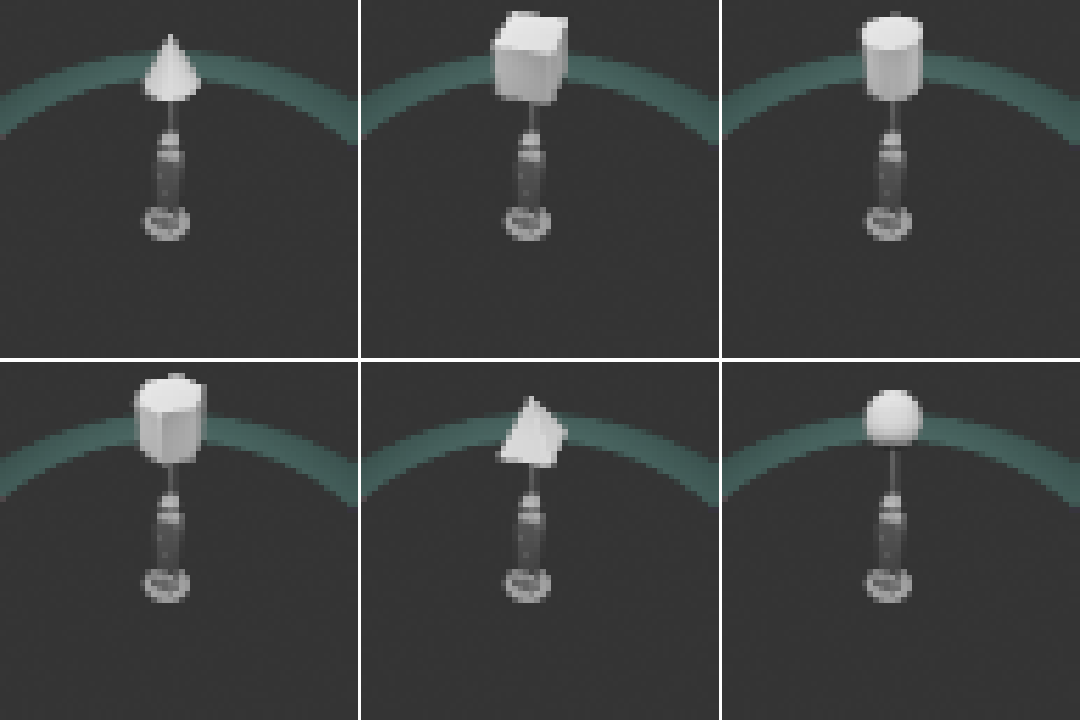

In [42]:
util.show_imgs(imgs)
pass

In [7]:
interventions = sample_full_interventions(dataset, num_groups=50, pbar=tqdm)
len(interventions)

  0%|          | 0/6 [00:00<?, ?it/s]

6

In [3]:
root = Path(r'C:\Users\anwan\Documents\workspace\sae\trained_nets')
run_names = os.listdir(str(root))
len(run_names)

238

In [4]:
print(tabulate(enumerate(run_names)))

---  -------------------------------------------------
  0  3ds_ae0_e-c12_d-c12_210125-045343
  1  3ds_ae0_e-c12_d-c12_coord_210125-045521
  2  3ds_ae0_e-c12_d-c12_mish_210125-050038
  3  3ds_ae0_e-c12_d-c12_res-nn_210125-045937
  4  3ds_ae0_e-c12_d-c12_res_210125-045520
  5  3ds_ae0_e-c12_d-s12_210125-045438
  6  3ds_ae0_e-c12_d-s12_coord_210125-050236
  7  3ds_ae0_e-c12_d-s12_mish_210125-050335
  8  3ds_ae0_e-c12_d-s12_nosplit_210125-045438
  9  3ds_ae0_e-c12_d-s12_res-nn_210125-050336
 10  3ds_ae0_e-c12_d-s12_res_210125-050235
 11  3ds_ae0_e-c12_d-s2_210125-132645
 12  3ds_ae0_e-c12_d-s2_nosplit_210125-134343
 13  3ds_ae0_e-c12_d-s3_210125-134123
 14  3ds_ae0_e-c12_d-s3_nosplit_210125-134835
 15  3ds_ae0_e-c12_d-s4_210125-045438
 16  3ds_ae0_e-c12_d-s4_mish_210125-140253
 17  3ds_ae0_e-c12_d-s4_nosplit_210125-045440
 18  3ds_ae0_e-c12_d-s4_seed2_210125-133117
 19  3ds_ae0_e-c12_d-s6_210125-045438
 20  3ds_ae0_e-c12_d-s6_lrp0003_210125-171518
 21  3ds_ae0_e-c12_d-s6_lrp0004_210125-17

In [220]:
run_name = run_names[7] # s12 mish
# run_name = run_names[5] # s12
# run_name = random.choice(run_names)
run_name = run_names[0] # ae conv
# run_name = run_names[27] # l12

run_name = run_names[41]

# run_name = '3ds_vae2_e-c12_d-c12_210125-045344'
# run_name = '3ds_vae1_e-l12_d-l12_210125-045439'
# run_name = '3ds_vae16_e-c12_d-c12_210125-045345'

# run_name = short[0]


run_name

'3ds_wae1000_e-c12_d-c12_210125-221143'

In [221]:
load_config = fig.get_config(path=run_name, root=str(root), **{'override.device':device})
load_config.set_silent(True)
run = fig.run('load-run', load_config)

Loading Config (for run): C:\Users\anwan\Documents\workspace\sae\trained_nets\3ds_wae1000_e-c12_d-c12_210125-221143\config.yaml


In [222]:
A = run.get_config()
A.set_silent(True)
info = A.pull('info')
info

{'arch_type': 'c12',
 'dataset_type': '3ds',
 'dec_type': 'c12',
 'enc_type': 'c12',
 'model_type': 'wae',
 'size': 64}

In [223]:
# B = A.pull('dataset.batch_size', 128)
# N = 16

In [224]:
# full = run.get_results('eval')
# print(full.keys())
# # X = full['original']
# # R = full['reconstruction']
# Q = full['latent']
# if isinstance(Q, distrib.Distribution):
#     Q = Q.loc
# Q.shape

In [225]:
# diff = (X-R).abs().mean(1)
# error = diff.view(B, -1).sum(-1)
# error.shape

In [226]:
# error

In [227]:
model = run.get_model()
model.switch_to('val')
model.to(device)
pass

Hybrid_Gaussian_WAE(
  (encoder): MultiLayer(
    (layers): ModuleList(
      (0): ConvLayer(
        residual=False
        (conv): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
        (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
        (nonlin): ELU(alpha=1.0, inplace=True)
      )
      (1): ConvLayer(
        residual=False
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
        (nonlin): ELU(alpha=1.0, inplace=True)
      )
      (2): ConvLayer(
        residual=False
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
        (nonlin): ELU(alpha=1.0, inplace=True)
      )
      (3): ConvLayer(
        residual=False
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), 

In [228]:
# dataset = run.get_dataset()
# dataset.switch_to('val')
# len(dataset)

In [229]:
# if R is None:
#     with torch.no_grad():
#         R, Q = model(X, ret_q=True)
#         if isinstance(Q, distrib.Distribution):
#             Q = Q.loc

In [230]:
# util.show_imgs(X[:N])
# plt.suptitle('Original')
# plt.subplots_adjust(top=0.95)
# util.show_imgs(R[:N])
# plt.suptitle('Reconstructions')
# plt.subplots_adjust(top=0.95)
# pass

In [231]:
fullQ = []
total = 10000
bs = 100
loader = dataset.get_loader(infinite=True, shuffle=True, seed=0, batch_size=bs)
loader = iter(loader)
pbar = tqdm(total=total)
while len(fullQ) < total//bs:
    batch = next(loader)
    x = model._process_batch(batch).original
    with torch.no_grad():
        q = model.encode(x)
        if isinstance(q, distrib.Distribution):
            q = q.loc
        fullQ.append(q)
    pbar.update(bs)
del loader
fullQ = torch.cat(fullQ)
fullQ.shape

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/10000 [00:00<?, ?it/s]

torch.Size([10000, 12])

In [232]:
scales = fullQ.std(0)
# scales = None

<IPython.core.display.Javascript object>


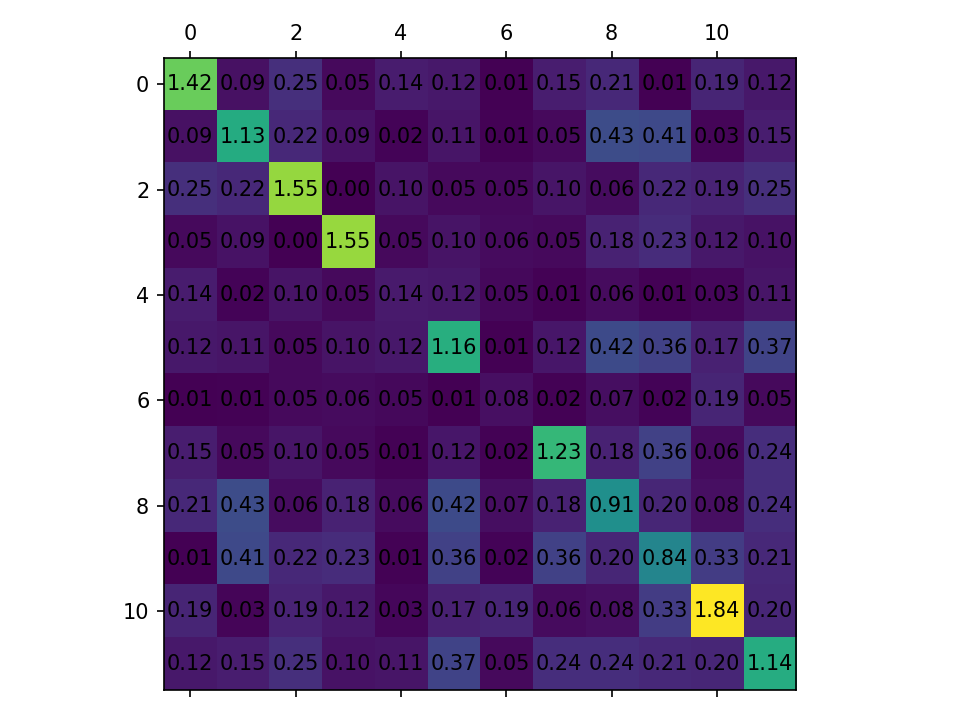

In [233]:
C = np.cov(fullQ.cpu().t().numpy())
util.plot_mat(C, val_fmt=2)
plt.tight_layout()
util.save_figure(f'{run_name}_cov', root=figure_dir)

In [234]:
R = response_mat(fullQ[:100], model.encode, model.decode, scales=scales, dist_type='rms', force_different=True)

<IPython.core.display.Javascript object>


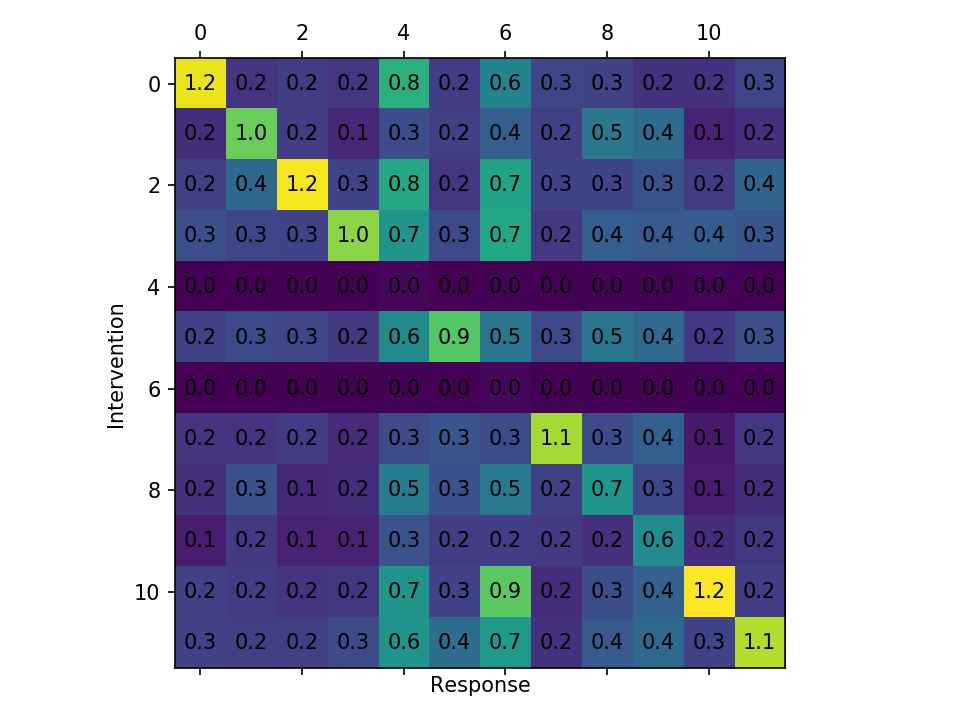

In [235]:
util.plot_mat(R, val_fmt=1) # responses
plt.ylabel('Intervention')
plt.xlabel('Response')
plt.tight_layout()
util.save_figure(f'{run_name}_responses', root=figure_dir)

<IPython.core.display.Javascript object>


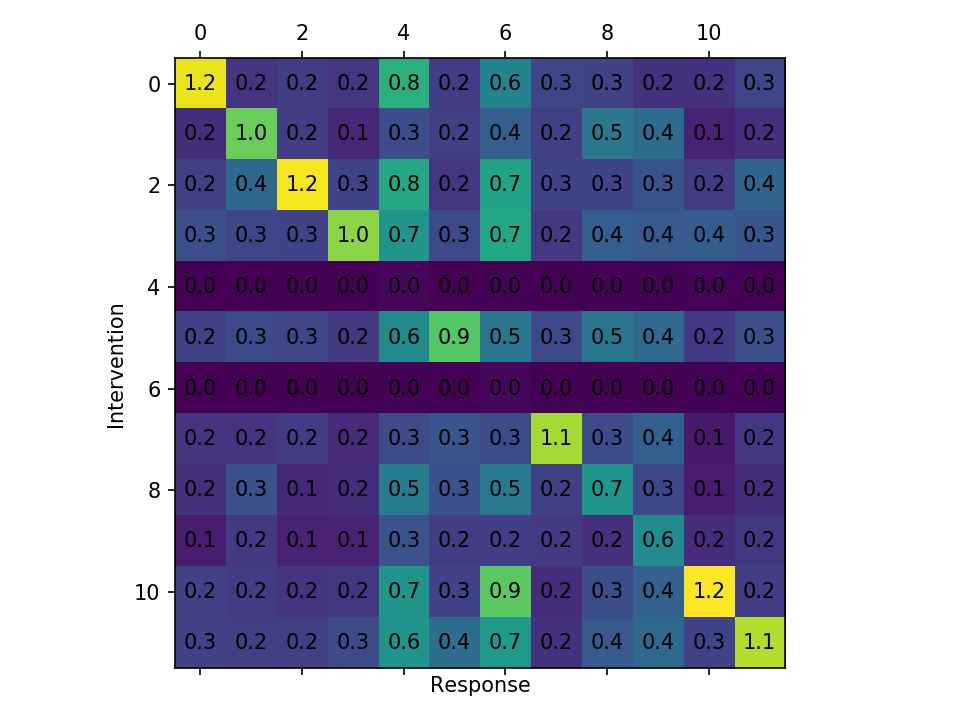

In [245]:
util.plot_mat(R, val_fmt=1) # responses
plt.ylabel('Intervention')
plt.xlabel('Response')
plt.tight_layout()
util.save_figure(f'{run_name}_responses', root=figure_dir)

<IPython.core.display.Javascript object>


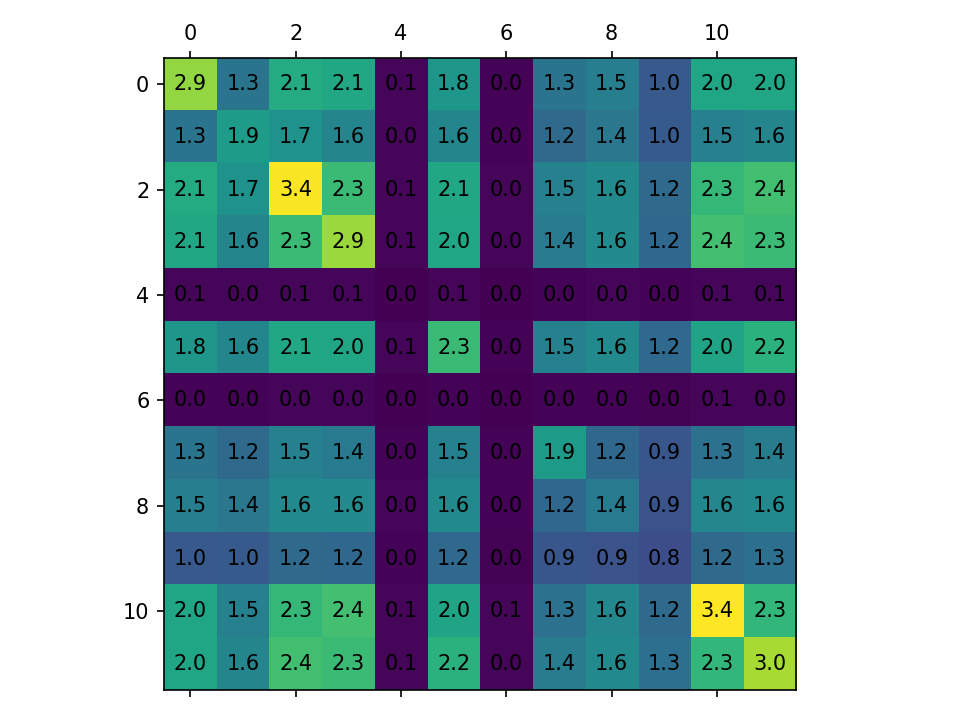

In [246]:
util.plot_mat((R @ R.t()), val_fmt=1) # interactions?
plt.tight_layout()
util.save_figure(f'{run_name}_interactions', root=figure_dir)

In [247]:
mats, lts = factor_reponses(model.encode, model.decode, interventions, pbar=tqdm, include_q=True, 
                       resp_kwargs=dict(scales=scales,force_different=True))
# W = mats.mean(-1).mean(1)

M = mats.min(1)[0].max(-1)[0]
# M = mats.mean(1).max(-1)[0]

mats.shape, len(lts), M.shape

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

(torch.Size([6, 50, 12, 12]), 6, torch.Size([6, 12]))

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


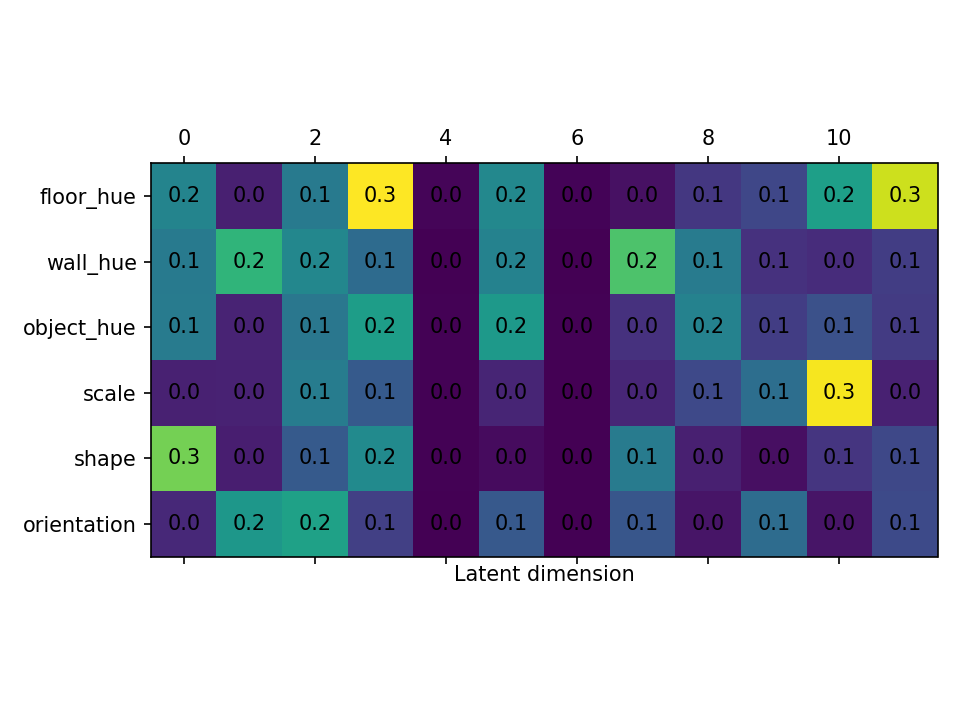

In [248]:
util.plot_mat(M, val_fmt=1)
plt.yticks(range(len(factors)), factors)
plt.xlabel('Latent dimension')
plt.tight_layout()
util.save_figure(f'{run_name}_factor-responses', root=figure_dir)
pass # an intervention on which latent dimension responds the most given that the intervention can 
#      only change the given factor of variation

In [249]:
mats.shape

torch.Size([6, 50, 12, 12])

In [264]:
# util.plot_mat(W, val_fmt=1);

In [252]:
tot = M.max(0)[0].sum() / M.sum()
# tot = M.sum(0).sub(wt)#.div(wt)#.sum().div(12)
# util.plot_mat(tot, val_fmt=1);
tot

tensor(0.5065, device='cuda:0')

In [255]:
# best = M.clamp(max=1)
# util.plot_mat(best.max(1)[0].unsqueeze(0), val_fmt=1);

In [256]:
# best = M.clamp(max=1)
# util.plot_mat(best.max(0)[0].unsqueeze(0), val_fmt=1);

<IPython.core.display.Javascript object>


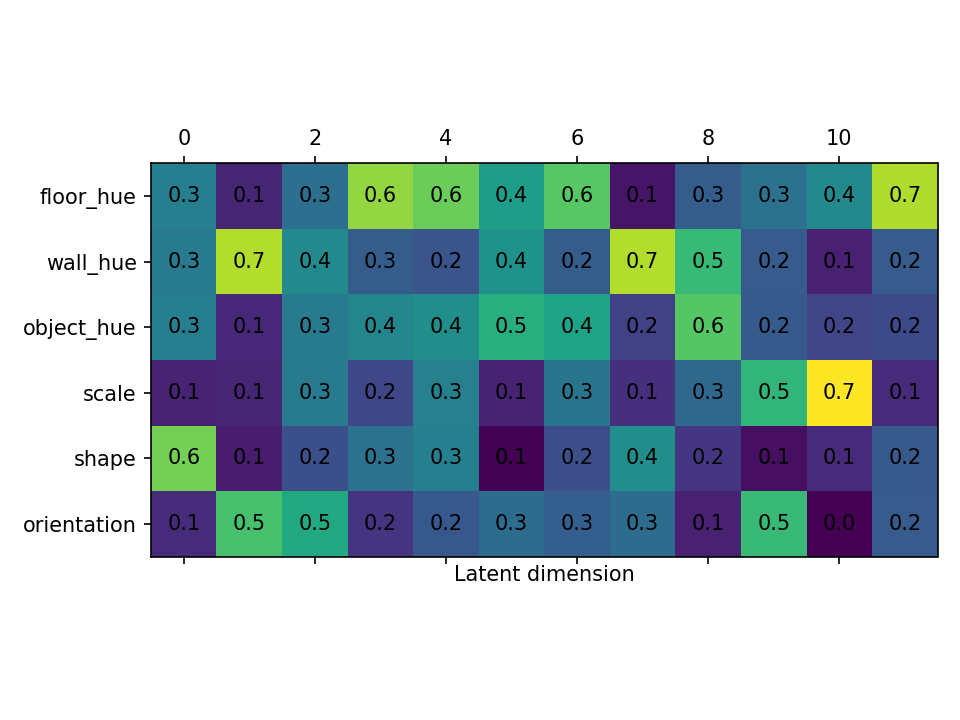

In [267]:
changes = torch.stack([(x - x.mean(1,keepdim=True)).pow(2).sqrt().div(scales).mean(1) for x in lts]).mean(1)
util.plot_mat(changes, val_fmt=1);
plt.yticks(range(len(factors)), factors)
plt.xlabel('Latent dimension')
plt.tight_layout()
util.save_figure(f'{run_name}_factor-latent-changes', root=figure_dir)

In [254]:
# util.plot_mat(mats.sum(2).mean(1), val_fmt=1)
# plt.yticks(range(len(factors)), factors)
# plt.xlabel('Latent dimension')
# plt.tight_layout()
# util.save_figure(f'{run_name}_factor-responses', root=figure_dir)
# pass # which latent dimension responds the most to interventions in the given factor of variation